Open-loop poles = [1.         1.         0.46195118 0.87279415]
Open-loop zeroes = [-0.77390768+0.j -0.95566712+0.j]
Closed-loop poles = [0.07939405 0.58859207 0.85019422 0.84361883]
Closed-loop zeroes = [-0.77390768+0.j -0.95566712+0.j]
Observer poles = [6.57215245e-01 4.21323851e-01 3.99997056e-06 3.99997069e-06]


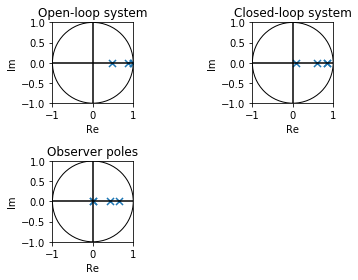

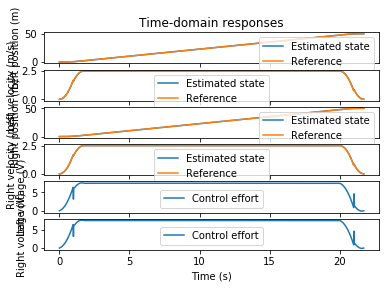

FileNotFoundError: [Errno 2] No such file or directory: 'drivetrain10.csv'

In [20]:
import frccontrol as frccnt
import matplotlib.pyplot as plt
import numpy as np
import control
import numpy
from frc3223_azurite.data import read_csv
from frc3223_azurite.conversions import *

class Drivetrain(frccnt.System):
    def __init__(self, dt):
        """Drivetrain subsystem.
        Keyword arguments:
        dt -- time between model/controller updates
        """
        state_labels = [
            ("Left position", "m"),
            ("Left velocity", "m/s"),
            ("Right position", "m"),
            ("Right velocity", "m/s"),
        ]
        u_labels = [("Left voltage", "V"), ("Right voltage", "V")]
        self.set_plot_labels(state_labels, u_labels)

        self.in_low_gear = True

        # Number of motors per side
        self.num_motors = 2.0

        # Drivetrain mass in kg
        self.m = lbs_to_kg(110)
        # Radius of wheels in meters
        self.r = inch_to_meter(3)
        # Radius of robot in meters
        self.rb = inch_to_meter(23)
        # Moment of inertia of the drivetrain in kg-m^2
        self.J = 3.0


        self.Gl = self.Gr = 10.75

        self.model = frccnt.models.drivetrain(
            frccnt.models.MOTOR_CIM,
            self.num_motors,
            self.m,
            self.r,
            self.rb,
            self.J,
            self.Gl,
            self.Gr,
        )
        
        A=numpy.array([
                [  0.        ,   1.        ,   0.        ,   0.        ],
                [  0.        , -18.70879036,   0.        ,  15.90601316],
                [  0.        ,   0.        ,   0.        ,   1.        ],
                [  0.        ,  15.90601316,   0.        , -18.70879036]])
        B=numpy.array([
                [ 0.        ,  0.        ],
                [ 6.61359246, -5.33282046],
                [ 0.        ,  0.        ],
                [-5.33282046,  6.61359246]])
        C=numpy.array([[1, 0, 0, 0],
                           [0, 0, 1, 0]])
        D=numpy.zeros(shape=(2,2))
        #self.model = control.ss(A, B, C, D)
        u_min = np.matrix([[-12.0], [-12.0]])
        u_max = np.matrix([[12.0], [12.0]])
        frccnt.System.__init__(self, self.model, u_min, u_max, dt)

        q_pos = 0.12
        q_vel = 1.0

        q = [q_pos, q_vel, q_pos, q_vel]
        r = [12.0, 12.0]
        self.design_dlqr_controller(q, r)

        qff_pos = 0.005
        qff_vel = 1.0
        self.design_two_state_feedforward(
            [qff_pos, qff_vel, qff_pos, qff_vel], [12.0, 12.0]
        )

        q_pos = 0.05
        q_vel = 1.0
        q_voltage = 9.0
        q_encoder_uncertainty = 2.0
        r_pos = 0.0001
        r_gyro = 0.000001
        self.design_kalman_filter([q_pos, q_vel, q_pos, q_vel], [r_pos, r_pos])
        

dt=0.02
drivetrain = Drivetrain(dt=dt)
try:
    import slycot

    plt.figure(1)
    drivetrain.plot_pzmaps()
except ImportError:  # Slycot unavailable. Can't show pzmaps.
    pass

t, xprof, vprof, aprof = frccnt.generate_s_curve_profile(
        max_v=2.5, max_a=3.5, time_to_max_a=1.0, dt=dt, goal=50.0
)

refs = []
for i in range(len(t)):
    r = np.matrix([[xprof[i]], [vprof[i]], [xprof[i]], [vprof[i]]])
    refs.append(r)
    
plt.figure(2)
state_rec, ref_rec, u_rec = drivetrain.generate_time_responses(t, refs)
drivetrain.plot_time_responses(t, state_rec, ref_rec, u_rec)
plt.show()




data = read_csv("drivetrain10.csv")
s = 5
e = len(data["time"])
ts = data["time"][s:e]
bus_voltages = data["voltage"][s:e]
percentVLeft = data["VRL"][s:e]
percentVRight = -data["VPR"][s:e]
voltages_l = (bus_voltages * percentVLeft)
voltages_r = bus_voltages * percentVRight
encPosL = data["enc_pos_l"][s:e]
encPosR = -data["enc_pos_r"][s:e]

vsl=data["enc_vel_l"][s:e]
vsr=-data["enc_vel_r"][s:e]
sim_encpos_l = numpy.zeros(shape=ts.shape)
sim_encpos_r = numpy.zeros(shape=ts.shape)
sim_encvel_l = numpy.zeros(shape=ts.shape)
sim_encvel_r = numpy.zeros(shape=ts.shape)

print(vsl[0], vsr[0], encPosL[0], encPosR[0])
drivetrain.reset()
drivetrain.x[0] = encPosL[0] / 630. / 3.28
drivetrain.x[1] = vsl[0] / 630 / 3.28 * 10
drivetrain.x[2] = encPosR[0] / 630. / 3.28
drivetrain.x[3] = vsr[0] / 630 / 3.28 * 10
print(drivetrain.x)
for i, t in enumerate(ts):
    sim_encpos_l[i] = drivetrain.x[0] * 630 * 3.28
    sim_encpos_r[i] = drivetrain.x[2] * 630 * 3.28
    sim_encvel_l[i] = drivetrain.x[1] * 630 * 3.28 / 10
    sim_encvel_r[i] = drivetrain.x[3] * 630 * 3.28 / 10
    u = numpy.matrix([
        [voltages_l[i],],
        [voltages_r[i],],
    ])
    drivetrain.x = drivetrain.sysd.A * drivetrain.x + drivetrain.sysd.B * u
    drivetrain.y = drivetrain.sysd.C * drivetrain.x + drivetrain.sysd.D * u
    

plt.plot(ts, voltages_r)
plt.plot(ts, voltages_l)
plt.legend(["right voltage", "left voltage"])
plt.show()

plt.plot(ts, encPosL, color="green")
plt.plot(ts, sim_encpos_l, color="orange")
plt.ylabel("left position")
plt.legend(["actual", "simulated"])
plt.show()

plt.plot(ts, encPosR, color="green")
plt.plot(ts, sim_encpos_r, color="orange")
plt.ylabel("right position")
plt.legend(["actual", "simulated"])
plt.show()

plt.plot(ts, vsl, color="green")
plt.plot(ts, sim_encvel_l, color="orange")
plt.legend(["actual", "simulated"])
plt.ylabel("left velocity")
plt.show()

plt.plot(ts, vsr, color="green")
plt.plot(ts, sim_encvel_r, color="orange")
plt.legend(["actual", "simulated"])
plt.ylabel("right velocity")
plt.show()



In [21]:
for a in ["A", "B","C","D"]:
    print (a+" = ", repr(getattr(drivetrain.sysd, a)))
    print("")
    
for a in ["K", "Kff", "L"]:
    print(a+" = ", repr(getattr(drivetrain, a)))
    print("")
    
ainv = numpy.linalg.inv(drivetrain.sysd.A)
print("Ainv = ", repr(ainv))

print("A continuous: ", repr(drivetrain.sysc.A))
print("")
print("B continuous: ", repr(drivetrain.sysc.B))

A =  matrix([[1.        , 0.01631643, 0.        , 0.00238268],
        [0.        , 0.66737266, 0.        , 0.20542149],
        [0.        , 0.00238268, 1.        , 0.01631643],
        [0.        , 0.20542149, 0.        , 0.66737266]])

B =  matrix([[ 0.00123499, -0.00079884],
        [ 0.11152021, -0.06887181],
        [-0.00079884,  0.00123499],
        [-0.06887181,  0.11152021]])

C =  matrix([[1, 0, 0, 0],
        [0, 0, 1, 0]])

D =  matrix([[0, 0],
        [0, 0]])

K =  matrix([[56.82612189,  6.03969859, 18.60045886,  3.51953103],
        [18.60045886,  3.51953103, 56.82612189,  6.03969859]])

Kff =  matrix([[731.26285269,   1.74253981, 334.3110478 ,   0.86234499],
        [334.3110478 ,   0.86234499, 731.26285269,   1.74253981]])

L =  matrix([[1.12809912, 0.08747579],
        [5.70458841, 4.3576656 ],
        [0.08747579, 1.12809912],
        [4.3576656 , 5.70458841]])

Ainv =  matrix([[ 1.        , -0.02579361,  0.        ,  0.0043692 ],
        [ 0.        ,  1.65523823, 

In [20]:
dir(drivetrain)

['Gl',
 'Gr',
 'J',
 'K',
 'Kff',
 'L',
 'P_steady',
 'Q',
 'R',
 '_System__default',
 '_System__make_cost_matrix',
 '_System__make_cov_matrix',
 '_System__update_observer',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 'correct_observer',
 'design_dlqr_controller',
 'design_kalman_filter',
 'design_two_state_feedforward',
 'export_cpp_coeffs',
 'extract_row',
 'generate_time_responses',
 'in_low_gear',
 'm',
 'model',
 'num_motors',
 'place_controller_poles',
 'place_observer_poles',
 'plot_pzmaps',
 'plot_time_responses',
 'predict_observer',
 'r',
 'rb',
 'reset',
 'set_plot_labels',
 'state_labels',
 'sysc',
 'sysd',
 'u',
 'u_labels',
 'u_max',
 'u_min',
 'updat

In [12]:
frccnt.models.cnt.ss.__doc__

'ss(A, B, C, D[, dt])\n\n    Create a state space system.\n\n    The function accepts either 1, 4 or 5 parameters:\n\n    ``ss(sys)``\n        Convert a linear system into space system form. Always creates a\n        new system, even if sys is already a StateSpace object.\n\n    ``ss(A, B, C, D)``\n        Create a state space system from the matrices of its state and\n        output equations:\n\n        .. math::\n            \\dot x = A \\cdot x + B \\cdot u\n\n            y = C \\cdot x + D \\cdot u\n\n    ``ss(A, B, C, D, dt)``\n        Create a discrete-time state space system from the matrices of\n        its state and output equations:\n\n        .. math::\n            x[k+1] = A \\cdot x[k] + B \\cdot u[k]\n\n            y[k] = C \\cdot x[k] + D \\cdot u[ki]\n\n        The matrices can be given as *array like* data types or strings.\n        Everything that the constructor of :class:`numpy.matrix` accepts is\n        permissible here too.\n\n    Parameters\n    ----------\n   